# Psychoacoustic Perceptual Loss Function Demo

## Install libraries

In [1]:
!pip install asteroid



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 246 kB 6.6 MB/s 
     |████████████████████████████████| 58 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 40.4 MB/s 
     |████████████████████████████████| 585 kB 44.8 MB/s 
     |████████████████████████████████| 72 kB 862 kB/s 
     |████████████████████████████████| 398 kB 52.3 MB/s 
     |████████████████████████████████| 101 kB 10.6 MB/s 
     |████████████████████████████████| 90 kB 7.7 MB/s 
     |████████████████████████████████| 140 kB 57.9 MB/s 
     |████████████████████████████████| 1.1 MB 43.7 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 46.1 MB/s 
     |████████████████████████████████| 144 kB 58.4 MB/s 
  Created wheel for torch-stoi: filename=torch_stoi-0.1.2-py3-none-any.whl size=6201 sha256=45f53d2dfa1c3de354eb313eddf09492d2462bf054b17751e9abb2d468da23bf

## Import Libraries

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from numpy.fft import fft, ifft
import torch.nn as nn
from asteroid.losses import SingleSrcMultiScaleSpectral, SingleSrcPMSQE

## Signal Processing Parameters


In [3]:
# Signal Processing Parameters

fs = 48000 # [Hz]
maxfreq=fs/2
duration = 2 # [s]
n_fft = 2**17
alpha=0.8  #Exponent for non-linear superposition of spreading functions
nfilts=64  #number of subbands in the bark domain


## Signals

In [104]:
# Sinusoids
x1=torch.sin(2*torch.pi/n_fft*2404*torch.arange(n_fft))
x2=torch.sin(2*torch.pi/n_fft*(2404+1000)*torch.arange(n_fft))*0.005
x3=torch.sin(2*torch.pi/n_fft*(2404+2000)*torch.arange(n_fft))*0.005
x4=torch.sin(2*torch.pi/n_fft*(2404+4000)*torch.arange(n_fft))*0.002

In [105]:
# Noise mT in Silence
def noisefromdBSpectrum(spec,fs):
    #produces noise according to the dB spectrum given in spec
    #Spectrum goes from frequency 0 up to Nyquist frequency
    specvoltage=10.0**(spec/20.0)
    #produce 40 blocks of sound:
    #Noise in the range of -1...+1, and Multiply noise with spectrum:
    noisespec=specvoltage*(np.random.rand(len(specvoltage))-0.5)*2
    #make spectrum symmetric for ifft: 
    #trick: Append zeros to fill up negative frequencies in upper half of DFT, then take real part of inverse transform:
    noisespec=np.concatenate((noisespec, np.zeros(len(noisespec))))
    noise_ifft=np.real(ifft(noisespec,norm='ortho'))
    noise=noise_ifft
    return (noise, fs)

f=np.linspace(0,fs/2,n_fft//2)
LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.)),-20,60)
#LTQ=(3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.- 3.3)**2.)+1e-3*((f/1000.)**4.))
#LTQ/=np.abs(LTQ).max()
#Shift dB according to our internal representation:
LTQ=LTQ-60
#Play back noise shaped like the masking theshold in quoet:
#Normalize
shaped_noise_mT, fs = noisefromdBSpectrum(LTQ,fs)
shaped_noise_mT/=np.abs(shaped_noise_mT).max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in power


In [122]:
# Signals X and Y in Time
x = x1.float()
y = (x1 + x2 + x3 + +x4 + shaped_noise_mT).float()
silence = torch.zeros(n_fft).float()
silent_noise = torch.from_numpy(shaped_noise_mT).float()

In [123]:
# Signals X and Y in Frequency
freqs = torch.fft.rfftfreq(n_fft)
x_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(x,norm='ortho'))+1e-12)
y_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(y,norm='ortho'))+1e-12)
silence_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(silence,norm='ortho'))+1e-12)
silent_noise_fft_mag = 20*torch.log(torch.abs(torch.fft.rfft(silent_noise,norm='ortho'))+1e-12)

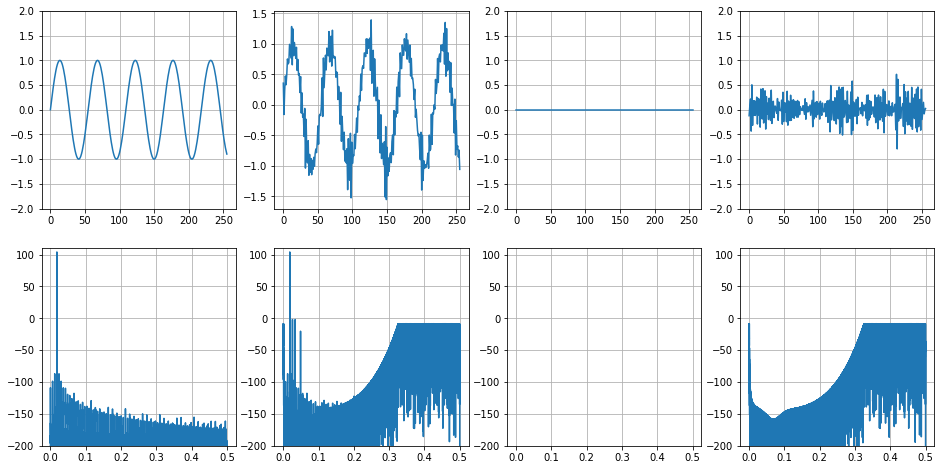

In [124]:
plt.figure(figsize=(16,8))
plt.subplot(2, 4, 1)
plt.plot(x.detach()[:256])
plt.ylim([-2,2])
plt.grid()
plt.subplot(2, 4, 2)
plt.plot(y.detach()[:256])
plt.grid()
plt.subplot(2, 4, 3)
plt.plot(silence.detach()[:256])
plt.ylim([-2,2])
plt.grid()
plt.subplot(2, 4, 4)
plt.plot(silent_noise.detach()[20000:20000+256])
plt.ylim([-2,2])
plt.grid()
plt.subplot(2, 4, 5)
plt.plot(freqs, x_fft_mag)
plt.ylim([-200,110])
plt.grid()
plt.subplot(2, 4, 6)
plt.plot(freqs, y_fft_mag)
plt.ylim([-200,110])
plt.grid()
plt.subplot(2, 4, 7)
plt.plot(freqs, silence_fft_mag)
plt.ylim([-200,110])
plt.grid()
plt.subplot(2, 4, 8)
plt.plot(freqs, silent_noise_fft_mag)
plt.ylim([-200,110])
plt.grid()

In [125]:
# Playback
print('x')
display(ipd.Audio(x.detach(),rate=fs))
print('y')
display(ipd.Audio(y.detach(),rate=fs))
print('silence')
display(ipd.Audio(silence.detach(),rate=fs))
print('silent noise')
display(ipd.Audio(silent_noise.detach(),rate=fs))

x


y


silence


/usr/local/lib/python3.7/dist-packages/IPython/lib/display.py:135: RuntimeWarning: invalid value encountered in true_divide
  scaled = np.int16(data/np.max(np.abs(data))*32767).tolist()


silent noise


## Psychoacoustic Model Functions

In [126]:
def hz2bark_torch(f):
        """ Usage: Bark=hz2bark(f)
            f    : (ndarray)    Array containing frequencies in Hz.
        Returns  :
            Brk  : (ndarray)    Array containing Bark scaled values.
        """
        if not torch.is_tensor(f):
          f = torch.tensor(f)

        Brk = 6. * torch.arcsinh(f/600.)                                           
        return Brk

In [127]:
def bark2hz_torch(Brk):
        """ Usage:
        Hz=bark2hs(Brk)
        Args     :
            Brk  : (ndarray)    Array containing Bark scaled values.
        Returns  :
            Fhz  : (ndarray)    Array containing frequencies in Hz.
        """
        if not torch.is_tensor(Brk):
          Brk = torch.tensor(Brk)
        Fhz = 600. * torch.sinh(Brk/6.)
        return Fhz

In [128]:
def mapping2barkmat_torch(fs, nfilts,nfft):
  #Constructing mapping matrix W which has 1's for each Bark subband, and 0's else
  #usage: W=mapping2barkmat(fs, nfilts,nfft)  
  #arguments: fs: sampling frequency
  #nfilts: number of subbands in Bark domain
  #nfft: number of subbands in fft
  maxbark=hz2bark_torch(fs/2) #upper end of our Bark scale:22 Bark at 16 kHz
  nfreqs=nfft/2; step_bark = maxbark/(nfilts-1)
  binbark = hz2bark_torch(torch.linspace(0,(nfft/2),(nfft//2)+1)*fs/nfft)
  W = torch.zeros((nfilts, nfft))
  for i in range(nfilts):
     W[i,0:int(nfft/2)+1] = (torch.round(binbark/step_bark)== i)
  return W

In [129]:
def mapping2bark_torch(mX,W,nfft):
  #Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
  #arguments: mX: magnitude spectrum from fft
  #W: mapping matrix from function mapping2barkmat
  #nfft: : number of subbands in fft
  #returns: mXbark, magnitude mapped to the Bark scale
  nfreqs=int(nfft/2)
  #Here is the actual mapping, suming up powers and conv. back to Voltages:
  mXbark = (torch.matmul( torch.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)
  return mXbark

In [130]:
def mappingfrombarkmat_torch(W,nfft):
  #Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale
  #usuage: W_inv=mappingfrombarkmat(Wnfft)
  #argument: W: mapping matrix from function mapping2barkmat
  #nfft: : number of subbands in fft
  nfreqs=int(nfft/2)
  W_inv= torch.matmul(torch.diag((1.0/(torch.sum(W,1)+1e-6))**0.5), W[:,0:nfreqs + 1]).T
  return W_inv

In [131]:
def mappingfrombark_torch(mTbark,W_inv,nfft):
  #usage: mT=mappingfrombark(mTbark,W_inv,nfft)
  #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
  # back to the linear scale
  #arguments:
  #mTbark: masking threshold in the Bark domain
  #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
  #nfft: : number of subbands in fft
  #returns: mT, masking threshold in the linear scale
  nfreqs=int(nfft/2)
  mT = torch.matmul(mTbark, W_inv[:, :nfreqs].T.float())
  return mT

In [132]:
def f_SP_dB_torch(maxfreq,nfilts):
   #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
   #computes the spreading function protoype, in the Bark scale.
   #Arguments: maxfreq: half the sampling freqency
   #nfilts: Number of subbands in the Bark domain, for instance 64   
   maxbark=hz2bark_torch(maxfreq) #upper end of our Bark scale:22 Bark at 16 kHz
   #Number of our Bark scale bands over this range: nfilts=64
   spreadingfunctionBarkdB=torch.zeros(2*nfilts)
   #Spreading function prototype, "nfilts" bands for lower slope 
   spreadingfunctionBarkdB[0:nfilts]=torch.linspace(-maxbark*27,-8,nfilts)-23.5
   #"nfilts" bands for upper slope:
   spreadingfunctionBarkdB[nfilts:2*nfilts]=torch.linspace(0,-maxbark*12.0,nfilts)-23.5
   return spreadingfunctionBarkdB

In [133]:
def spreadingfunctionmat_torch(spreadingfunctionBarkdB,alpha,nfilts):
   #Turns the spreading prototype function into a matrix of shifted versions.
   #Convert from dB to "voltage" and include alpha exponent
   #nfilts: Number of subbands in the Bark domain, for instance 64  
   spreadingfunctionBarkVoltage=10.0**(spreadingfunctionBarkdB/20.0*alpha)
   #Spreading functions for all bark scale bands in a matrix:
   spreadingfuncmatrix=torch.zeros((nfilts,nfilts))
   for k in range(nfilts):
      spreadingfuncmatrix[k,:]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]
   return spreadingfuncmatrix

In [134]:
def maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,alpha,fs,nfilts): 
  #Computes the masking threshold on the Bark scale with non-linear superposition
  #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
  #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
  #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
  #alpha: exponent for non-linear superposition (eg. 0.6), 
  #fs: sampling freq., nfilts: number of Bark subbands
  #nfilts: Number of subbands in the Bark domain, for instance 64  
  #Returns: mTbark: the resulting Masking Threshold on the Bark scale 
  
  #Compute the non-linear superposition:
  mTbark=torch.matmul(mXbark**alpha, spreadingfuncmatrix**alpha)
  #apply the inverse exponent to the result:
  mTbark=mTbark**(1.0/alpha)
  #Threshold in quiet:
  maxfreq=fs/2.0
  maxbark=hz2bark_torch(maxfreq)
  step_bark = maxbark/(nfilts-1)
  barks=torch.arange(0,nfilts)*step_bark
  #convert the bark subband frequencies to Hz:
  f=bark2hz_torch(barks)+1e-6
  #Threshold of quiet in the Bark subbands in dB:
  LTQ=torch.clip((3.64*(f/1000.)**-0.8 -6.5*torch.exp(-0.6*(f/1000.-3.3)**2.)
      +1e-3*((f/1000.)**4.)),-20,120)
  #Maximum of spreading functions and hearing threshold in quiet:
  a = mTbark
  b = 10.0**((LTQ-60)/20)
  mTbark=torch.max(a,b)
  return mTbark

## Psychoacoustic Loss Function

In [135]:
class PsychoAcousticLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_fft = 2048, return_complex= False, 
                 n_filts = 64, fs = 48000, alpha=0.8, mode = "mse_time"):
        super(PsychoAcousticLoss, self).__init__()
        self.n_fft = n_fft
        self.return_complex = return_complex
        self.n_filts = n_filts
        self.fs = fs
        self.maxfreq=fs//2
        self.alpha = alpha
        self.mode = mode
 
    def forward(self, x, y):
      # Compute STFT of x
      x_stft = torch.stft(x, self.n_fft, return_complex = self.return_complex)
      x_stft_mt = torch.zeros_like(x_stft)
      # Compute mT for every Block
      n_frames = x_stft.shape[1]
      W = mapping2barkmat_torch(self.fs, self.n_filts,self.n_fft)
      spreadingfunctionBarkdB=f_SP_dB_torch(self.maxfreq,self.n_filts)
      spreadingfuncmatrix=spreadingfunctionmat_torch(spreadingfunctionBarkdB,self.alpha, self.n_filts)
      for frame in range(n_frames):
        stft_frame = x_stft[:,frame,0]
        mXbark=mapping2bark_torch(stft_frame,W,self.n_fft)
        mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,self.alpha,self.fs,self.n_filts)
        W_inv = mappingfrombarkmat_torch(W,self.n_fft)
        mT=mappingfrombark_torch(mTbark,W_inv,self.n_fft)
        x_stft_mt[:,frame,0]=stft_frame * mT**-1
      
      # Compute STFT of Y
      y_stft = torch.stft(y, self.n_fft, return_complex = self.return_complex)
      y_stft_mt = torch.zeros_like(y_stft)
      # Compute mT for every Block
      n_frames = y_stft.shape[1]
      W = mapping2barkmat_torch(self.fs, self.n_filts,self.n_fft)
      spreadingfunctionBarkdB=f_SP_dB_torch(self.maxfreq,self.n_filts)
      spreadingfuncmatrix=spreadingfunctionmat_torch(spreadingfunctionBarkdB,self.alpha, self.n_filts)
      for frame in range(n_frames):
        stft_frame = y_stft[:,frame,0]
        mXbark=mapping2bark_torch(stft_frame,W,self.n_fft)
        mTbark=maskingThresholdBark_torch(mXbark,spreadingfuncmatrix,self.alpha,self.fs,self.n_filts)
        W_inv = mappingfrombarkmat_torch(W,self.n_fft)
        mT=mappingfrombark_torch(mTbark,W_inv,self.n_fft)
        y_stft_mt[:,frame,0]=stft_frame * mT**-1
        
      if self.mode == "mse_frequency":
        x = x_stft_mt.flatten()
        y = y_stft_mt.flatten()
        mse = torch.nn.MSELoss()
        return mse(x_stft_mt,y_stft_mt)

      # Compute ISTFT of x
      x_istft = torch.istft(x_stft_mt, self.n_fft, return_complex = self.return_complex)
      # Compute ISTFT of y
      y_istft = torch.istft(y_stft_mt, self.n_fft, return_complex = self.return_complex)

      # Compute Difference
      if self.mode == "mse_time":
        mse = torch.nn.MSELoss()
        return mse(x_istft,y_istft)
      if self.mode == "multiscale":
        loss_multiScaleSpectral = SingleSrcMultiScaleSpectral()
        return loss_multiScaleSpectral(x_istft.unsqueeze(dim=0),y_istft.unsqueeze(dim=0))
      if self.mode == "l1":
        l1_loss = nn.L1Loss()
        return l1_loss(x_istft,y_istft)



# Compare Losses

In [136]:
loss_mse = torch.nn.MSELoss()
print('mse:', loss_mse(x,y))
psychoLoss_mse = PsychoAcousticLoss()
print('psychoLoss mse:', psychoLoss_mse(x,y))
print('ratio mse/psycho:', loss_mse(x,y)/psychoLoss_mse(x,y))
loss_multiScaleSpectral = SingleSrcMultiScaleSpectral()
print('Multi Scale Spectral:', loss_multiScaleSpectral(x.unsqueeze(dim=0),y.unsqueeze(dim=0)))
psychoLoss_multiscale = PsychoAcousticLoss(mode='multiscale')
print('psychoLoss multiscale:', psychoLoss_multiscale(x,y))
print('ratio multiscale/psycho_multiscale:', loss_multiScaleSpectral(x.unsqueeze(dim=0),y.unsqueeze(dim=0))/psychoLoss_multiscale(x,y))
l1_loss = nn.L1Loss()
print('L1 Loss:', l1_loss(x,y))
l1_psycho = PsychoAcousticLoss(mode='l1')
print('Psycho L1 Loss:', l1_psycho(x,y))
print('ratio l1/psycho L1:', l1_loss(x,y)/l1_psycho(x,y))




mse: tensor(0.0525)
psychoLoss mse: tensor(0.0003)
ratio mse/psycho: tensor(203.2013)
Multi Scale Spectral: tensor([3175474.5000])
psychoLoss multiscale: tensor([1257385.6250])
ratio multiscale/psycho_multiscale: tensor([2.5255])
L1 Loss: tensor(0.1830)
Psycho L1 Loss: tensor(0.0125)
ratio l1/psycho L1: tensor(14.6113)


In [137]:
loss_mse = torch.nn.MSELoss()
print('mse:', loss_mse(silence,silent_noise))
psychoLoss_mse = PsychoAcousticLoss()
print('psychoLoss mse:', psychoLoss_mse(silence,silent_noise))
print('ratio mse/psycho:', loss_mse(silence,y)/psychoLoss_mse(silence,silent_noise))
loss_multiScaleSpectral = SingleSrcMultiScaleSpectral()
print('Multi Scale Spectral:', loss_multiScaleSpectral(silence.unsqueeze(dim=0),silent_noise.unsqueeze(dim=0)))
psychoLoss_multiscale = PsychoAcousticLoss(mode='multiscale')
print('psychoLoss multiscale:', psychoLoss_multiscale(silence,silent_noise))
print('ratio multiscale/psycho_multiscale:', loss_multiScaleSpectral(silence.unsqueeze(dim=0),silent_noise.unsqueeze(dim=0))/psychoLoss_multiscale(silence,silent_noise))
l1_loss = nn.L1Loss()
print('L1 Loss:', l1_loss(silence,silent_noise))
l1_psycho = PsychoAcousticLoss(mode='l1')
print('Psycho L1 Loss:', l1_psycho(silence,silent_noise))
print('ratio l1/psycho L1:', l1_loss(silence,silent_noise)/l1_psycho(x,silent_noise))

mse: tensor(0.0525)
psychoLoss mse: tensor(0.0004)
ratio mse/psycho: tensor(1487.0603)
Multi Scale Spectral: tensor([4583413.5000])
psychoLoss multiscale: tensor([3934707.5000])
ratio multiscale/psycho_multiscale: tensor([1.1649])
L1 Loss: tensor(0.1830)
Psycho L1 Loss: tensor(0.0139)
ratio l1/psycho L1: tensor(12.0001)
